In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNetCV
import numpy as np
from sklearn.metrics import r2_score
import warnings
import math
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [3]:
df = pd.read_json('data/raw/fics.ndjson', lines = True)
#df = pd.read_json("data/raw/stockfish_150.ndjson", lines = True)
df = df.fillna(0)

In [6]:
print(len(df))
df = df.dropna(subset=['white_elo', 'black_elo'])
print(len(df))
df = df[df['white_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['black_cpl'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['maia_cpl_w'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
df = df[df['maia_cpl_b'].apply(lambda x: isinstance(x, (list, str)) and len(x) > 0)]
print(len(df))
df['white_elo'] = pd.to_numeric(df['white_elo'], errors='coerce')
df['black_elo'] = pd.to_numeric(df['black_elo'], errors='coerce')


df["ECO"] = df["ECO"].astype('category')
df["Opening"] = df["Opening"].astype('category')
df["result"] = df["result"].astype('category')

df["mean_elos"] = df[['white_elo', 'black_elo']].mean(axis=1)
df["diff_elos"] = df['white_elo'] - df['black_elo']

df['white_mean'] = df['white_cpl'].apply(np.mean)
df['white_std'] = df['white_cpl'].apply(np.std)
df['white_min'] = df['white_cpl'].apply(np.min)
df['white_max'] = df['white_cpl'].apply(np.max)

df['black_mean'] = df['black_cpl'].apply(np.mean)
df['black_std'] = df['black_cpl'].apply(np.std)
df['black_min'] = df['black_cpl'].apply(np.min)
df['black_max'] = df['black_cpl'].apply(np.max)

df['stockfish_mean'] = df['stockfish_eval'].apply(np.mean)
df['stockfish_std'] = df['stockfish_eval'].apply(np.std)
df['stockfish_min'] = df['stockfish_eval'].apply(np.min)
df['stockfish_max'] = df['stockfish_eval'].apply(np.max)

df['maia_w_mean'] = df['maia_cpl_w'].apply(np.mean)
df['maia_w_std'] = df['maia_cpl_w'].apply(np.std)
df['maia_w_min'] = df['maia_cpl_w'].apply(np.min)
df['maia_w_max'] = df['maia_cpl_w'].apply(np.max)

df['maia_b_mean'] = df['maia_cpl_b'].apply(np.mean)
df['maia_b_std'] = df['maia_cpl_b'].apply(np.std)
df['maia_b_min'] = df['maia_cpl_b'].apply(np.min)
df['maia_b_max'] = df['maia_cpl_b'].apply(np.max)

dep_var = "mean_elos"

17817
17817
12818


In [7]:
df.to_json('data/curated/FICS_MAIA.ndjson', orient='records', lines=True)

In [13]:
cont = ['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at', 'total_moves', 'end_r',
 'end_p', 'end_b', 'end_n', 'end_q', 'end_N', 'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
 'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean', 'black_std', 'black_min', 'black_max', 'stockfish_mean',
 'stockfish_std', 'stockfish_min', 'stockfish_max', 'maia_w_mean',
 'maia_w_std', 'maia_w_min', 'maia_w_max', 'maia_b_mean',
 'maia_b_std', 'maia_b_min', 'maia_b_max']

In [39]:
results = pd.get_dummies(df["result"])
openings = pd.get_dummies(df["Opening"])



X = pd.concat([df[cont], results, openings], axis = 1)
X = X.fillna(0)

num = 10000

y1 = df["mean_elos"]
y2 = df["diff_elos"]

X_train, X_test = X[:num], X[num:]
y1_train, y1_test = df["mean_elos"][:num], df["mean_elos"][num:]
y2_train, y2_test = df["diff_elos"][:num], df["diff_elos"][num:]

Looking at the cross validation results, it looks like 100 estimators is enough.

In [18]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_mean = RandomForestRegressor(n_estimators=num, n_jobs=-1)
    rf_mean.fit(X_train, y1_train)
    mean_pred_rf = rf_mean.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(mean_absolute_error(y1_test, mean_pred_rf))
    print(r2_score(y1_test, mean_pred_rf))
    print("----------------------------------")

RF model with 30 estimators.
185.56569050153774
0.1660668813310311
----------------------------------
RF model with 50 estimators.
184.2345203453986
0.17935983487895246
----------------------------------
RF model with 100 estimators.
183.86244573574638
0.18550841968079734
----------------------------------
RF model with 150 estimators.
184.0842967694451
0.1835183039457885
----------------------------------
RF model with 250 estimators.
183.19637016627803
0.18999286885173516
----------------------------------
RF model with 350 estimators.
183.70382228997585
0.18832696354163758
----------------------------------


Similarly, 100 estimators seems to be enough.

In [19]:
nums = [30, 50, 100, 150, 250, 350]

for num in nums:
    rf_diff = RandomForestRegressor(n_estimators=num, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
    rf_diff.fit(X_train, y2_train)
    dff_pred_rf = rf_diff.predict(X_test)
    print(f"RF model with {num} estimators.")
    print(mean_absolute_error(y2_test, dff_pred_rf))
    print(r2_score(y2_test, dff_pred_rf))
    print("----------------------------------")

RF model with 30 estimators.
134.42122139048226
0.13076853282190337
----------------------------------
RF model with 50 estimators.
133.54630687550312
0.1347466444147205
----------------------------------
RF model with 100 estimators.
132.80281444769764
0.14224970568064566
----------------------------------
RF model with 150 estimators.
132.90752382763375
0.14335176523951332
----------------------------------
RF model with 250 estimators.
132.35836227338143
0.14539869418031004
----------------------------------
RF model with 350 estimators.
132.63168286911633
0.14577837687381445
----------------------------------


c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\jonat\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:432: 

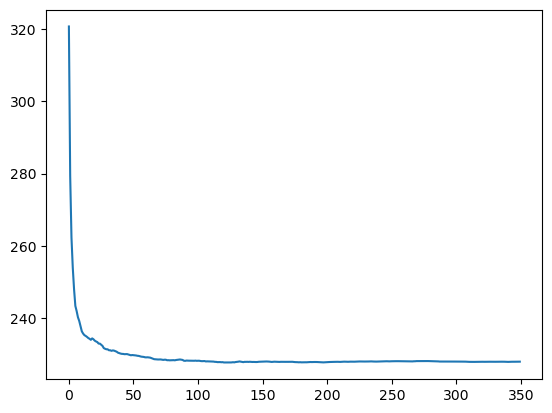

In [20]:
import matplotlib.pyplot as plt
preds = np.stack([t.predict(X_test) for t in rf_mean.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), y1_test) for i in range(350)]);

In [21]:

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

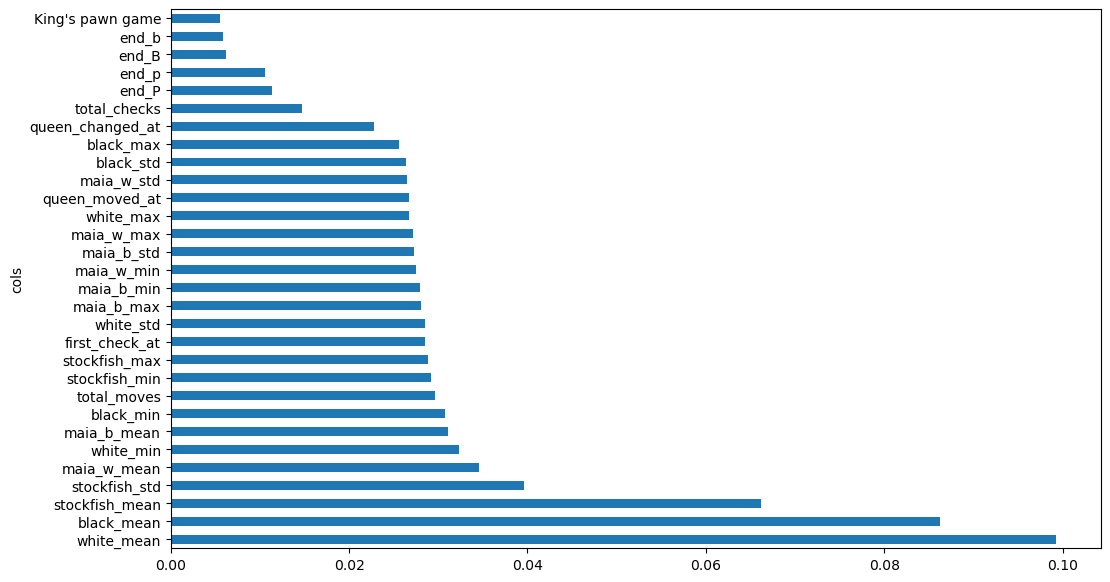

In [25]:
fi_mean = rf_feat_importance(rf_mean, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi_mean[:30]);

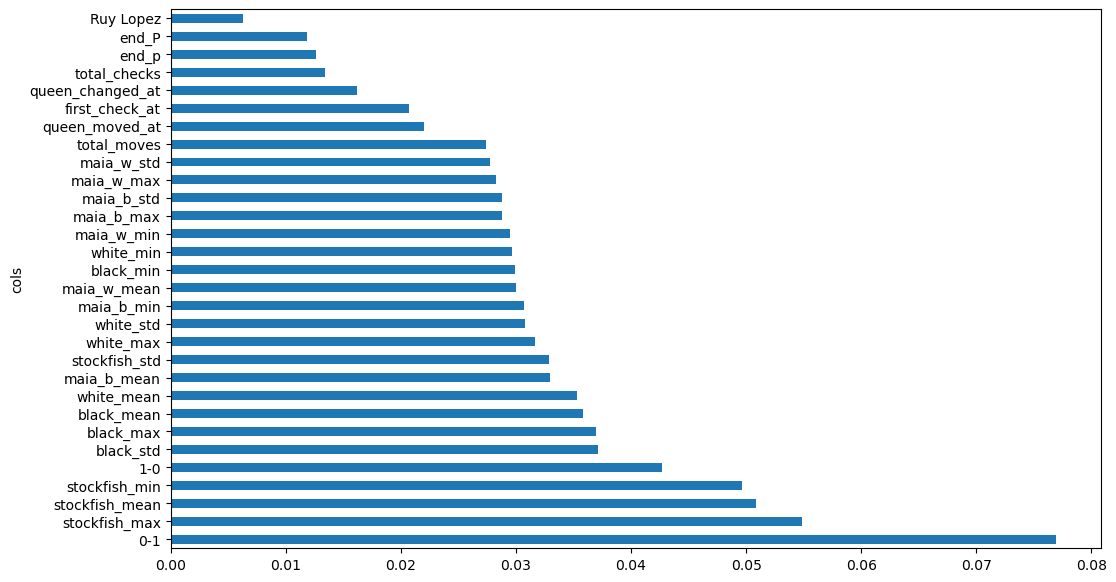

In [27]:
fi_diff = rf_feat_importance(rf_diff, X_train)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi_diff[:30]);

In [28]:
to_keep_diff = fi_diff[fi_diff.imp>0.01].cols
print(len(to_keep_diff))
print((to_keep_diff))

29
37                 0-1
28       stockfish_max
25      stockfish_mean
27       stockfish_min
38                 1-0
22           black_std
24           black_max
21          black_mean
17          white_mean
33         maia_b_mean
26       stockfish_std
20           white_max
18           white_std
35          maia_b_min
29         maia_w_mean
23           black_min
19           white_min
31          maia_w_min
36          maia_b_max
34          maia_b_std
32          maia_w_max
30          maia_w_std
4          total_moves
0       queen_moved_at
2       first_check_at
3     queen_changed_at
1         total_checks
6                end_p
11               end_P
Name: cols, dtype: object


In [29]:
to_keep_mean = fi_mean[fi_mean.imp>0.01].cols
print(len(to_keep_mean))
print((to_keep_mean))

27
17          white_mean
21          black_mean
25      stockfish_mean
26       stockfish_std
29         maia_w_mean
19           white_min
33         maia_b_mean
23           black_min
4          total_moves
27       stockfish_min
28       stockfish_max
2       first_check_at
18           white_std
36          maia_b_max
35          maia_b_min
31          maia_w_min
34          maia_b_std
32          maia_w_max
20           white_max
0       queen_moved_at
30          maia_w_std
22           black_std
24           black_max
3     queen_changed_at
1         total_checks
11               end_P
6                end_p
Name: cols, dtype: object


In [34]:
white_pred = []
black_pred = []

for i in range(len(dff_pred_rf)):
    white_pred.append(mean_pred_rf[i] + dff_pred_rf[i]/2)
    black_pred.append(mean_pred_rf[i] - dff_pred_rf[i]/2)


all_preds = white_pred + black_pred

In [35]:
len(all_preds)

5636

In [40]:
white_actual = []
black_actual = []
for ind, row in df[num:].iterrows():
    white_actual.append(row["white_elo"])
    black_actual.append(row["black_elo"])

all_actual = white_actual + black_actual

In [41]:
len(all_actual)

5636

In [42]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(all_actual, all_preds)

196.63948697455888

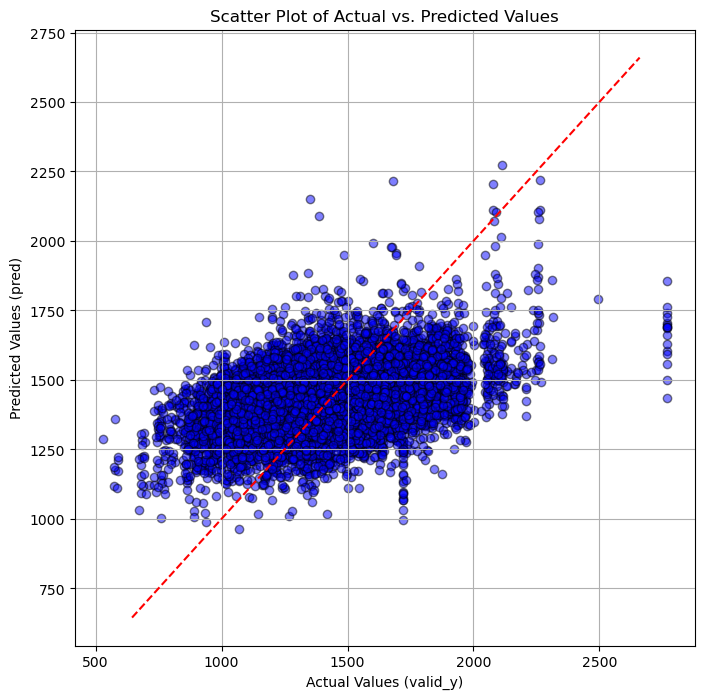

In [175]:
import matplotlib.pyplot as plt

# Assuming valid_y and pred are your actual and predicted values
# valid_y = [your actual values]
# pred = [your predicted values]

plt.figure(figsize=(8, 8))
plt.scatter((all_actual), (all_preds), edgecolor='k', color='b', alpha=0.5)

# Adding a diagonal line to indicate perfect predictions
plt.plot([min(y1), max(y1)], [min(y1), max(y1)], 'r--')

# Adding titles and labels
plt.title('Scatter Plot of Actual vs. Predicted Values')
plt.xlabel('Actual Values (valid_y)')
plt.ylabel('Predicted Values (pred)')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

In [43]:

print(mean_absolute_error(all_actual, all_preds))
print(r2_score(all_actual, all_preds))

196.63948697455888
0.18221413561862665


In [52]:
import joblib
results = pd.get_dummies(df["result"])

X = pd.concat([df[cont], results], axis = 1)
X = X.fillna(0)

y1 = df["diff_elos"]
y2 = df["mean_elos"]


rf_diff = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_diff.fit(X[to_keep_diff], y1)

rf_mean = RandomForestRegressor(n_estimators=100, n_jobs=-1, min_samples_leaf=4, max_features=0.5)
rf_mean.fit(X[to_keep_mean], y2)




RandomForestRegressor(max_features=0.5, min_samples_leaf=4, n_jobs=-1)

In [53]:
X.columns

Index(['queen_moved_at', 'total_checks', 'first_check_at', 'queen_changed_at',
       'total_moves', 'end_r', 'end_p', 'end_b', 'end_n', 'end_q', 'end_N',
       'end_P', 'end_Q', 'end_B', 'end_R', 'promotion', 'can_claim_draw',
       'white_mean', 'white_std', 'white_min', 'white_max', 'black_mean',
       'black_std', 'black_min', 'black_max', 'stockfish_mean',
       'stockfish_std', 'stockfish_min', 'stockfish_max', 'maia_w_mean',
       'maia_w_std', 'maia_w_min', 'maia_w_max', 'maia_b_mean', 'maia_b_std',
       'maia_b_min', 'maia_b_max', '0-1', '1-0', '1/2-1/2'],
      dtype='object')

In [56]:

# Save the trained model to a file
joblib.dump(rf_mean, 'rf_mean.pkl')
joblib.dump(rf_diff, 'rf_diff.pkl')

['rf_diff.pkl']